## Executive Summary

This project explored two datasets from the Centers of Medicare & Medicaid Services (CMS) on nursing home ownership composition, and penalties issued to nursing homes by CMS and how much the nursing homes were fined. The purpose was to determine if there were differences ownership composition between nursing homes that received fines versus those that did not receive fines. We discovered that nursing homes with ownerships that were predominantly organizational in nature seemed to be fined more often than ownerships that were predominantly female.

## Introduction

Nursing homes receive fines from CMS if they appear to endanger or injure residents, or for poor financial management (Amirkhanyan, Meier, O’Toole Jr., Dakhwe, & Janzen, 2018). Fines put nursing homes on notice that they need to improve their practices or risk going out of business (Drevs, Tscheulin, & Lindenmeier, 2014). This is important not just for healthcare administration but for the residents of nursing homes themselves: lower quality of life can be tied to increased healthcare spending and greater inefficiency in the healthcare system (Konetzka, Norton, & Stearns, 2006).

The purpose of this study was to determine the relationship between nursing home ownership composition and the prevalence of fines among nursing homes. Skilled nursing facilities (SNFs) who accept Medicare for payment are subject to quality and data collection standards that SNFs who do not accept Medicare have no need to contend with (Eramo, 2019). However, the data collected by these Medicare-accepting SNFs is important to understanding how SNFs succeed or fail to meet quality of life expectations of their residents. Previous literature has demonstrated that SNF ownership and staffing levels are correlated to such outcomes as hospitalizations and early death in short- and long-term SNF residents (Hirth, Grabowski, Feng, Rahman, & Mor, 2014). It is worth exploring whether gender dimensions of SNF ownership also correlate or can predict these adverse outcomes.

We will be looking at the ownership dimensions of SNFs in order to predict likelihood that any given SNF will receive a fine from CMS. Namely, we will be looking at private versus public ownership, corporate or otherwise, and for SNFs who maintain a board of owners, whether the gender composition of the ownership groups can predict likelihood that a SNF will receive a fine. These are important questions to ask because it is already known in the extant literature that dimensions such as these lead to increases or reductions in rates of hospitalizations and early deaths in both short- and long-term SNF residents (Mezuk, Lohman, Leslie, & Powell, 2015).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier

In [2]:
df_ownership = pd.read_csv('Ownership.csv')
df_penalties = pd.read_csv('Penalty_Counts.csv')
names = pd.read_csv('names_dataset.csv')

## EDA and Clean-Up

Below, we take a look at our data and figure out what to do with it.

In [3]:
df_ownership.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167341 entries, 0 to 167340
Data columns (total 13 columns):
Federal Provider Number                        167341 non-null object
Provider Name                                  167341 non-null object
Provider Address                               167341 non-null object
Provider City                                  167341 non-null object
Provider State                                 167341 non-null object
Provider Zip Code                              167341 non-null int64
Role played by Owner or Manager in Facility    167341 non-null object
Owner Type                                     166570 non-null object
Owner Name                                     166570 non-null object
Ownership Percentage                           166570 non-null object
Association Date                               166570 non-null object
Location                                       167094 non-null object
Processing Date                                167

We can see that our data on nursing home ownership contains 13 features and 167,341 observations.

In [4]:
df_penalties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15491 entries, 0 to 15490
Data columns (total 9 columns):
Federal Provider Number             15491 non-null object
Provider Name                       15491 non-null object
Provider State                      15491 non-null object
Number of Fines                     15491 non-null int64
Total Amount of Fines in Dollars    15491 non-null float64
Number of Payment Denials           15491 non-null int64
Total Number of Penalties           15491 non-null int64
Location                            15468 non-null object
Processing Date                     15491 non-null object
dtypes: float64(1), int64(3), object(5)
memory usage: 1.1+ MB


We can see that our data on nursing home fines contains 11 features and 15,491 observations. These 15,491 are each individual nursing facilities. We can see also that Federal Provider Number is the key on which we can join the data.

Now, we need to figure out which features in our ownership data are pertinent to our analysis.

In [5]:
ownership_cols = ['Federal Provider Number', 
                  'Provider Name', 
                  'Role played by Owner or Manager in Facility', 
                  'Owner Type', 
                  'Owner Name']

In [6]:
# taking out 'Ownership Percentage', limiting scope of project
df_ownership_reduced = df_ownership[ownership_cols]

In [7]:
df_ownership_reduced['Owner Type'].value_counts()

Individual      123621
Organization     42949
Name: Owner Type, dtype: int64

There are 123,621 observations of individual owners and 42,949 observations of organizations that own nursing homes. Since there are only 15,491 total nursing homes in the CMS dataset, we can infer that each nursing home has a high likelihood of having more than one owner. Let's verify our assumption:

In [8]:
df_ownership_reduced.sort_values('Federal Provider Number').head(15)

,Federal Provider Number,Provider Name,Role played by Owner or Manager in Facility,Owner Type,Owner Name
5363,015009,"BURNS NURSING HOME, INC.",5% OR GREATER DIRECT OWNERSHIP INTEREST,Individual,"DEARMAN, MARTHA"
18539,015009,"BURNS NURSING HOME, INC.",OFFICER,Individual,"DEARMAN, MARTHA"
13378,015009,"BURNS NURSING HOME, INC.",OFFICER,Individual,"DEARMAN, LARRY"
1149,015009,"BURNS NURSING HOME, INC.",5% OR GREATER DIRECT OWNERSHIP INTEREST,Individual,"DEARMAN, LARRY"
1698,015009,"BURNS NURSING HOME, INC.",MANAGING EMPLOYEE,Individual,"DEARMAN, MARTHA"
9400,015009,"BURNS NURSING HOME, INC.",DIRECTOR,Individual,"DEARMAN, MARTHA"
17293,015010,COOSA VALLEY HEALTHCARE CENTER,OPERATIONAL/MANAGERIAL CONTROL,Individual,"CHAPMAN, ARCHIE"
5640,015010,COOSA VALLEY HEALTHCARE CENTER,5% OR GREATER DIRECT OWNERSHIP INTEREST,Individual,"CHAPMAN, ARCHIE"
1922,015010,COOSA VALLEY HEALTHCARE CENTER,OFFICER,Individual,"CHAPMAN, ARCHIE"
12091,015010,COOSA VALLEY HEALTHCARE CENTER,OPERATIONAL/MANAGERIAL CONTROL,Organization,"PRIME MANAGEMENT, LLC"


Our assumption was correct.

Now let's separate out individuals owners from organization owners. From that, we will infer the gender of each individual owner.

In [9]:
organization = df_ownership_reduced['Owner Type'] == 'Organization'
individuals = df_ownership_reduced['Owner Type'] == 'Individual'

In [10]:
df_ownership_organizations = df_ownership_reduced[organization]
df_ownership_individuals = df_ownership_reduced[individuals]

We can only infer gender from first name, so we have to split that out from the complete name strings.

In [11]:
df_ownership_individuals[['last_name', 'first_name']] = df_ownership_individuals['Owner Name'].str.split(', ', n=1, expand=True)
df_ownership_individuals['first_name'] = df_ownership_individuals['first_name'].str.lower().str.capitalize()

C:\Users\tdrace\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\tdrace\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
df_ownership_individuals['first_name'].head()

0     Pamala
1        Jan
2    Timothy
3       Chad
4     Sheila
Name: first_name, dtype: object

Now we will use decision tree classification from scikit-learn in order to infer gender based on features found in the names. Our training data comes from a subset of Social Security Administration data found here: https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-national-level-data. We are following a tutorial found here: https://nlpforhackers.io/introduction-machine-learning/

First, we explore the dimensions of our training data:

In [13]:
print("%d names in dataset" % len(names)) 

95025 names in dataset


Now we define our names variable as being a matrix of all names found in the set and also designate the training split at 80%:

In [14]:
names = names.as_matrix()[:, 1:]
train_split = 0.8

C:\Users\tdrace\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


We define a function to extract the features from the name strings to form a basis for prediction:

In [15]:
def features(name):
    name = name.lower()
    return {
        'first-letter': name[0], # First letter
        'first2-letters': name[0:2], # First 2 letters
        'first3-letters': name[0:3], # First 3 letters
        'last-letter': name[-1],
        'last2-letters': name[-2:],
        'last3-letters': name[-3:],
    }

In [16]:
print(features("John"))

{'first-letter': 'j', 'first2-letters': 'jo', 'first3-letters': 'joh', 'last-letter': 'n', 'last2-letters': 'hn', 'last3-letters': 'ohn'}


We need to vectorize our features so that they can be interpreted by the learning algorithm:

In [17]:
features = np.vectorize(features)
print(features(["Anna", "Hannah", "Paul"]))

[{'first-letter': 'a', 'first2-letters': 'an', 'first3-letters': 'ann', 'last-letter': 'a', 'last2-letters': 'na', 'last3-letters': 'nna'}
 {'first-letter': 'h', 'first2-letters': 'ha', 'first3-letters': 'han', 'last-letter': 'h', 'last2-letters': 'ah', 'last3-letters': 'nah'}
 {'first-letter': 'p', 'first2-letters': 'pa', 'first3-letters': 'pau', 'last-letter': 'l', 'last2-letters': 'ul', 'last3-letters': 'aul'}]


Now we extract the features of the entire names dataset:

In [18]:
X = features(names[:, 0])

We also need the targets that we're predicting, in this case the gender found associated with each of the 95,025 names:

In [19]:
y = names[:, 1]

Now we'll test to see if we built the dataset correctly:

In [20]:
print("Name: %s, features=%s, gender=%s" % (names[0][0], X[0], y[0]))

Name: Mary, features={'first-letter': 'm', 'first2-letters': 'ma', 'first3-letters': 'mar', 'last-letter': 'y', 'last2-letters': 'ry', 'last3-letters': 'ary'}, gender=F


Success. Let's do our proper train/test split:

In [21]:
X, y = shuffle(X, y)
X_train, X_test = X[:int(train_split * len(X))], X[int(train_split * len(X)):]
y_train, y_test = y[:int(train_split * len(y))], y[int(train_split * len(y)):]

We'll check to see of we've done so correctly by seeing if the sets add up and pass through DictVectorizer in scikit-learn:

In [22]:
print(len(X_train), len(X_test), len(y_train), len(y_test)) 

76020 19005 76020 19005


In [23]:
print(features(["Mary", "John"]))
vectorizer = DictVectorizer()
vectorizer.fit(X_train)

[{'first-letter': 'm', 'first2-letters': 'ma', 'first3-letters': 'mar', 'last-letter': 'y', 'last2-letters': 'ry', 'last3-letters': 'ary'}
 {'first-letter': 'j', 'first2-letters': 'jo', 'first3-letters': 'joh', 'last-letter': 'n', 'last2-letters': 'hn', 'last3-letters': 'ohn'}]


DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
               sparse=True)

Now we transform our data for decision tree classification, test the accuracy of our results, and deploy our model to the nursing home ownership data:

In [24]:
transformed = vectorizer.transform(features(["Mary", "John"]))
clf = DecisionTreeClassifier()
clf.fit(vectorizer.transform(X_train), y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [25]:
# Accuracy on training set
print(clf.score(vectorizer.transform(X_train), y_train))

0.9875822152065246


In [26]:
# Accuracy on test set
print(clf.score(vectorizer.transform(X_test), y_test))

0.8665088134701394


In [27]:
nh_first_names = df_ownership_individuals['first_name'].tolist()

In [28]:
df_ownership_individuals['category'] = clf.predict(vectorizer.transform(features(nh_first_names)))

C:\Users\tdrace\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
df_ownership_individuals = df_ownership_individuals.drop(columns=['last_name', 'first_name'])

Let's see how we did:

In [30]:
df_ownership_individuals.head(10)

,Federal Provider Number,Provider Name,Role played by Owner or Manager in Facility,Owner Type,Owner Name,category
0,185310,THE EPISCOPAL CHURCH HOME,DIRECTOR,Individual,"THOMPSON, PAMALA",F
1,015019,MERRY WOOD LODGE CARE AND REHABILITATION CENTER,OFFICER,Individual,"EDWARDS, JAN",F
2,225724,"MEADOWS, THE",DIRECTOR,Individual,"VAILL, TIMOTHY",M
3,015084,PARK PLACE,DIRECTOR,Individual,"MCCURDY, CHAD",M
4,015104,SOUTHLAND NURSING HOME,DIRECTOR,Individual,"SASSER, SHEILA",F
5,015132,DIVERSICARE OF OXFORD,DIRECTOR,Individual,"MCCURDY, CHAD",M
6,015142,"LINEVILLE HEALTH AND REHABILITATION, LLC",DIRECTOR,Individual,"RICHBURG, JULIE",F
7,015167,MARION REGIONAL NURSING HOME,MANAGING EMPLOYEE,Individual,"TRIMM, ROBERT",M
8,015189,DIVERSICARE OF PELL CITY,DIRECTOR,Individual,"MCKNIGHT, JAMES",M
9,015208,"OZARK HEALTH AND REHABILITATION, LLC",DIRECTOR,Individual,"RICHBURG, JULIE",F


It's not perfect, but we've now made predictions as to the gender of each of the 123,621 individual owners found in the ownership data.

Now we need to classify our organizations. Simple enough since we're bucketing them all together. We'll just add a character to designate them:

In [31]:
df_ownership_organizations['category'] = 'O'

C:\Users\tdrace\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Let's pull the two ownership dataframes back together via concatenation:

In [32]:
df_ownership_categorized = pd.concat([df_ownership_individuals, df_ownership_organizations])

Turning our attention back to the dataset with the fines in it, we need a column that designates a Boolean of an observation being associated with a fine or not. Simple enough:

In [33]:
def f(row):
    if row['Total Amount of Fines in Dollars'] == 0.00:
        val = 1
    elif row['Total Amount of Fines in Dollars'] > 0.00:
        val = 0
    return val

In [34]:
df_penalties['Fined?'] = df_penalties.apply(f, axis=1)
df_penalties['Fined?'].value_counts()

1    10427
0     5064
Name: Fined?, dtype: int64

We can see that about a third of the nursing homes received fines.

The next step is tricky. For each key, in this case Federal Provider Number, we need to caluclate which of the three ownership categories appear more often than the other two, and then map that result onto our penalties data. The code to do so is as follows:

In [35]:
df_penalties['category'] = df_ownership_categorized['Federal Provider Number'].map(df_ownership_categorized.groupby('Federal Provider Number').category.value_counts().groupby(level=0).filter(lambda x: x.nunique() == len(x)).unstack().idxmax(1))

The next step introduces problems with our analysis, which we will cover in our closing remarks, but since not every key can be associated with an ownership category that appears most often, we will drop nulls here:

In [36]:
df_penalties_fined_categories = df_penalties[df_penalties['Fined?'] == 0].dropna()

Now it's time to visualize our results. We will create category weights in order to draw normed historgrams that show proportions of observations; but first we'll reindex our data because we want our categories to appear in the same order on our graphs:

In [37]:
categories_full = df_ownership_categorized['category'].sort_values()
categories_full.columns = pd.CategoricalIndex(['category'], ordered=True)
categories_fined = df_penalties_fined_categories['category'].sort_values()
categories_fined.columns = pd.CategoricalIndex(['category'], ordered=True)

First, these are the ownership compositions on the entire penalties dataset. This represents over 15,000 nursing homes which accept Medicare for payment:

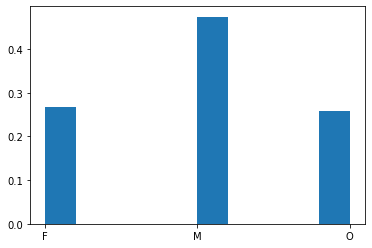

In [38]:
weights_full = np.ones_like(categories_full)/float(len(categories_full))
hist_full = plt.hist(categories_full, weights=weights_full)

In the entire dataset, about 25% of nursing homes that accept Medicare for payment are predominantly owned by females, about 50% owned by males, and about 25% are predominantly owned by other organizations.

Now let's look at the data for nursing homes which recevied fines; this is for about 4,000 nursing homes after NaN values are dropped:

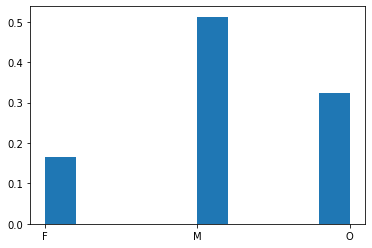

In [39]:
weights_fined = np.ones_like(categories_fined)/float(len(categories_fined))
hist_fined = plt.hist(categories_fined, weights=weights_fined)

We see that of the nursing homes that have received a fine in the last year, about 15% are predominantly owned by females, about 50% by males (the same as the full data), and about 35% by organizations.

In other words, it seems that nursing homes owned predominantly by females are less likely to receive fines, that male ownership appears to have no effect, and organizational ownership seems to result in higher likelihood of a nursing home receiving a fine.

## Limitations and Conclusion

A major problem with how the data was prepared for this exercise was the dropping of nulls after mapping categories onto penalties. This results in a possible oversampling of organizational data in the final predictions. However, at least in this run, the proportions of males to females appear to be the same, so further analysis on the breakdown and effect of these categories is needed. A data preparation method better suited to measurement like multinomial logistic regression, where categories each have their own feature counts as discrete buckets instead of the max frequency sampling we've done here, would have been perhaps better suited to what we were trying to do.

Regardless, this is important groundwork for prediciting the likelihood of fines based on ownership composition.

## References

Amirkhanyan, A. A., Meier, K. J., O’Toole Jr., L. J., Dakhwe, M. A., & Janzen, S. (2018). Management and Performance in US Nursing Homes. Journal of Public Administration Research & Theory, 28(1), 33. Retrieved from edb.

Drevs, F., Tscheulin, D. K., & Lindenmeier, J. (2014). Do Patient Perceptions Vary With Ownership Status? A Study of Nonprofit, For-Profit, and Public Hospital Patients. Nonprofit & Voluntary Sector Quarterly, 43(1), 164. Retrieved from edb.

Eramo, L. A. (2019). 7 tips to maximize revenue for nursing home services. Medical Economics, (1). Retrieved from http://ezproxy.bellevue.edu/login?url=https://search.ebscohost.com/login.aspx?direct=true&db=edsbig&AN=edsbig.A574852509&site=eds-live

Hirth, R., Grabowski, D., Feng, Z., Rahman, M., & Mor, V. (2014). Effect of nursing home ownership on hospitalization of long-stay residents: An instrumental variables approach. International Journal of Health Care Finance & Economics, 14(1), 1. Retrieved from edb.

Konetzka, R. T., Norton, E. C., & Stearns, S. C. (2006). Medicare Payment Changes and Nursing Home Quality: Effects on Long-Stay Residents. International Journal of Health Care Finance and Economics, 6(3), 173. https://doi.org/10.1007/s10754-006-9000-9

Mezuk, B., Lohman, M., Leslie, M., & Powell, V. (2015). Suicide Risk in Nursing Homes and Assisted Living Facilities 2003-2011. American Journal of Public Health, 105(7), 1495–1502. Retrieved from pbh.